In [1]:
import os
import sys
# sys.path.insert(0, os.path.dirname(os.path.abspath("")))
import torch
import random
import librosa
import numpy as np
from datasets import load_dataset
from IPython.display import Audio
from audiodiffusion import AudioDiffusion
from diffusers import (
    AudioPipelineOutput,
    AutoencoderKL,
    DDIMScheduler,
    DDPMScheduler,
    DiffusionPipeline,
    ImagePipelineOutput,
    UNet2DConditionModel,
)
from audiodiffusion import AudioDiffusionPipeline
from audiodiffusion.mel import Mel

2023-05-26 23:16:27.798522: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-26 23:16:27.824672: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 23:16:28.331529: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from typing import List

from torch import nn
from transformers import CLIPTokenizer, ClapTextModel


class CLIPTextEmbedder(nn.Module):
    """
    ## CLIP Text Embedder
    """

    def __init__(self, version: str = "laion/clap-htsat-unfused", device="cuda:0", max_length: int = 77):
        """
        :param version: is the model version
        :param device: is the device
        :param max_length: is the max length of the tokenized prompt
        """
        super().__init__()
        # Load the tokenizer
        self.tokenizer = CLIPTokenizer.from_pretrained(version)
        # Load the CLIP transformer
        self.transformer = ClapTextModel.from_pretrained(version).eval()

        self.device = device
        self.max_length = max_length

    def forward(self, prompts: List[str]):
        """
        :param prompts: are the list of prompts to embed
        """
        # Tokenize the prompts
        batch_encoding = self.tokenizer(prompts, truncation=True, max_length=self.max_length, return_length=True,
                                        return_overflowing_tokens=False, padding="max_length", return_tensors="pt")
        # Get token ids
        tokens = batch_encoding["input_ids"].to(self.device)
        # Get CLIP embeddings
        return self.transformer(input_ids=tokens).last_hidden_state

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = torch.Generator(device=device)

In [4]:
# audio_diffusion = AudioDiffusion(model_id="models/ddpm-ema-audio-64")
# mel = audio_diffusion.pipe.mel
vqvae = AutoencoderKL.from_pretrained("models/ddpm-ema-audio-64/vqvae/")
unet = UNet2DConditionModel.from_pretrained("models/ddpm-ema-audio-64/unet/")
scheduler = DDPMScheduler.from_pretrained("models/ddpm-ema-audio-64/scheduler/")
mel = Mel()

pipe = AudioDiffusionPipeline(
    vqvae=vqvae,
    unet=unet,
    scheduler=scheduler,
    mel=mel
)

In [5]:
clap = CLIPTextEmbedder()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'CLIPTokenizer'.
Some weights of the model checkpoint at laion/clap-htsat-unfused were not used when initializing ClapTextModel: ['audio_model.audio_encoder.layers.3.blocks.1.output.dense.bias', 'text_model.encoder.layer.0.output.LayerNorm.bias', 'text_model.encoder.layer.10.attention.self.key.weight', 'audio_model.audio_encoder.layers.1.downsample.reduction.weight', 'text_model.encoder.layer.9.attention.output.LayerNorm.weight', 'text_model.encoder.layer.3.output.dense.bias', 'text_model.encoder.layer.6.output.LayerNorm.bias', 'audio_model.audio_encoder.layers.2.blocks.1.layernorm_before.weight', 'text_model.encoder.layer.9.intermediate.dense.bias', 'text_model.encoder.layer.5.attention.self.key.weight', 'text_model.

In [6]:
pipe = pipe.to(device)
clap = clap.to(device)

clap.eval()

CLIPTextEmbedder(
  (transformer): ClapTextModel(
    (embeddings): ClapTextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ClapTextEncoder(
      (layer): ModuleList(
        (0-11): 12 x ClapTextLayer(
          (attention): ClapTextAttention(
            (self): ClapTextSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ClapTextSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay

In [13]:
prompt = clap.forward(prompts=["footsteps"]).to(device)

In [14]:
images, (sample_rate, audios) = pipe(
    batch_size=1,
    generator=generator,
    encoding=prompt,
    return_dict=False,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

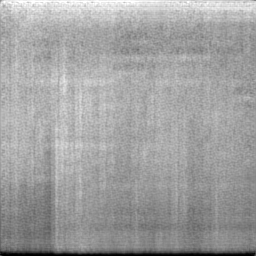

In [15]:
display(images[0])
display(Audio(audios[0], rate=sample_rate))
# loop = AudioDiffusion.loop_it(audio, sample_rate)
# if loop is not None:
#     display(Audio(loop, rate=sample_rate))
# else:
#     print("Unable to determine loop points")